# Imports

In [1]:
# !pip install yfinance

In [177]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import gmean

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import gc

np.random.seed(42069)
warnings.simplefilter('ignore')
%matplotlib inline

In [178]:
params = {
    'figure.figsize': (10, 5)
     }
plt.rcParams.update(params)

# Download Market Data

In [179]:
# This will download data from yahoo finance - more than enough for prototyping
df = yf.download(
        # tickers list or string as well
        tickers = "BTC-USD",
        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "3y",
        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",
        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',
        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,
        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,
        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,
        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

[*********************100%***********************]  1 of 1 completed


In [180]:
df.shape

(1093, 5)

In [181]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-10-19,6478.069824,6493.680176,6445.310059,6465.410156,3578870000
2018-10-20,6460.919922,6497.720215,6449.000000,6489.189941,3379130000
2018-10-21,6490.089844,6556.379883,6476.000000,6482.350098,3253610000
2018-10-22,6486.049805,6543.799805,6462.979980,6487.160156,3672860000
2018-10-23,6472.359863,6506.009766,6451.270020,6475.740234,3716150000


In [182]:
df['avg_price'] = gmean(df[['Open', 'High', 'Low', 'Close']], axis=1)

In [183]:
df.head()

,Open,High,Low,Close,Volume,avg_price
Date,,,,,,
2018-10-19,6478.069824,6493.680176,6445.310059,6465.410156,3578870000,6470.593302
2018-10-20,6460.919922,6497.720215,6449.000000,6489.189941,3379130000,6474.176830
2018-10-21,6490.089844,6556.379883,6476.000000,6482.350098,3253610000,6501.125279
2018-10-22,6486.049805,6543.799805,6462.979980,6487.160156,3672860000,6494.929309
2018-10-23,6472.359863,6506.009766,6451.270020,6475.740234,3716150000,6476.315557


In [184]:
nullvaluecheck = pd.DataFrame(df.isna().sum().sort_values(ascending=False)*100/df.shape[0],columns=['missing %']).head(60)
nullvaluecheck.style.background_gradient(cmap='PuBu')

,missing %
Open,0.000000
High,0.000000
Low,0.000000
Close,0.000000
Volume,0.000000
avg_price,0.000000


In [185]:
returns = np.log(df['Close']).diff()
returns.dropna(inplace=True)

# EDA

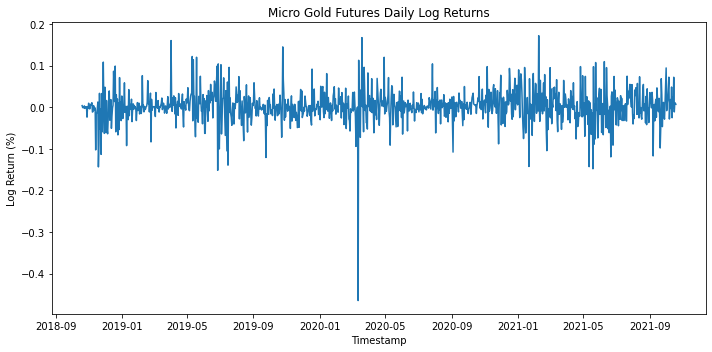

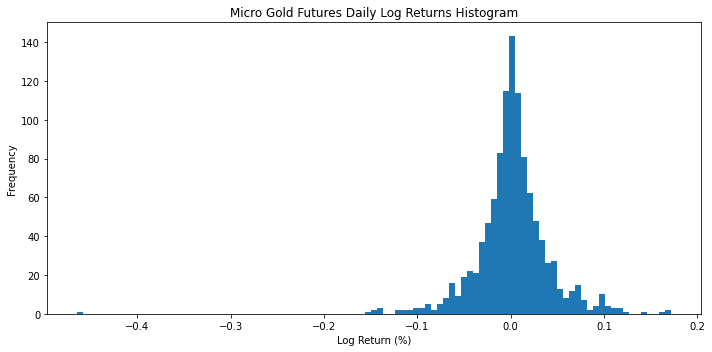

In [186]:
plt.figure()
plt.plot(returns)
plt.title('Micro Gold Futures Daily Log Returns')
plt.xlabel('Timestamp')
plt.ylabel('Log Return (%)')
plt.tight_layout()

plt.figure()
plt.hist(returns, bins='auto')
plt.title('Micro Gold Futures Daily Log Returns Histogram')
plt.ylabel('Frequency')
plt.xlabel('Log Return (%)')
plt.tight_layout()

In [187]:
# 70 - 30 Train Test
split = int(0.3*len(returns))
X = returns[:-split]
X_test = returns[-split:]

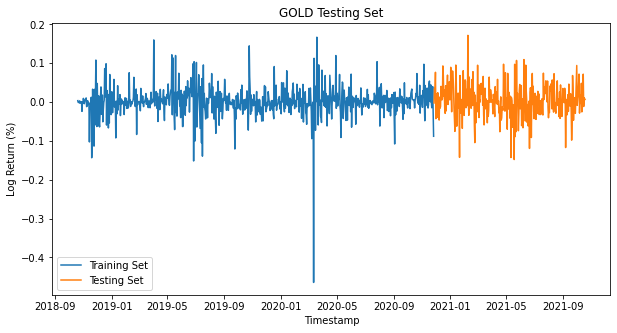

In [188]:
plt.plot(X, label='Training Set')
plt.plot(X_test, label='Testing Set')
plt.title(label='GOLD Testing Set')
plt.xlabel('Timestamp')
plt.ylabel('Log Return (%)')
plt.legend()
plt.show()

# Modelling

In [189]:
# !pip install hmmlearn

In [190]:
from hmmlearn import hmm

In [191]:
X = X.to_numpy().reshape(-1, 1)
X_test = X_test.to_numpy().reshape(-1, 1)

In [192]:
model = hmm.GaussianHMM(
    # 2 States
    n_components=2,
    covariance_type="diag",
    verbose=True
)

In [193]:
%%time
model.fit(X)
model.transmat_ 

Wall time: 43.1 ms


         1        1251.4710             +nan
         2        1424.3478        +172.8767
         3        1472.5766         +48.2288
         4        1527.0705         +54.4939
         5        1555.4562         +28.3857
         6        1565.8106         +10.3544
         7        1569.5259          +3.7153
         8        1571.1904          +1.6644
         9        1572.1337          +0.9434
        10        1572.7454          +0.6117


array([[0.81426445, 0.18573555],
       [0.54659967, 0.45340033]])

In [194]:
# Adjust the probabilities for transitioning states
model.transmat_ = np.array(
    [
        [0.9, 0.1],
        [0.1, 0.9]
    ]
)

In [195]:
Z = model.predict(X_test)
Z_train = model.predict(X)


#this where I take an online approach
Z_cap = [model.predict(X_test[:i+1])[-1] for i in range(len(X_test))]
Z_cap = np.array(Z_cap)


# Evaluation

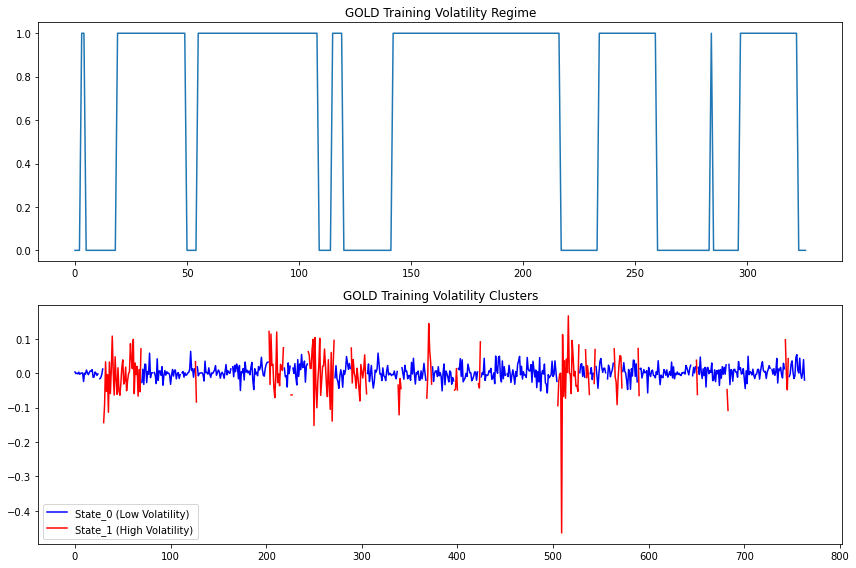

In [196]:
# Compute State Changes
returns_train0 = np.empty(len(Z_train))
returns_train1 = np.empty(len(Z_train))
returns_train0[:] = np.nan
returns_train1[:] = np.nan

# Create series for each state change
returns_train0[Z_train == 0] = returns[:-split][Z_train == 0]
returns_train1[Z_train == 1] = returns[:-split][Z_train == 1]


fig, ax = plt.subplots(figsize=(12,8))

# Plot the Volatility Regime and the states
plt.subplot(211)
plt.plot(Z)
plt.title(label='GOLD Training Volatility Regime')

plt.subplot(212)
plt.plot(returns_train0, label='State_0 (Low Volatility)', color='b')
plt.plot(returns_train1, label='State_1 (High Volatility)', color='r', )
plt.title(label='GOLD Training Volatility Clusters')
plt.legend()
plt.tight_layout()

In [197]:
print(np.nanmedian(returns_train0))
np.nanmedian(returns_train1)

0.0013681074096147938


-0.0018230728528463302

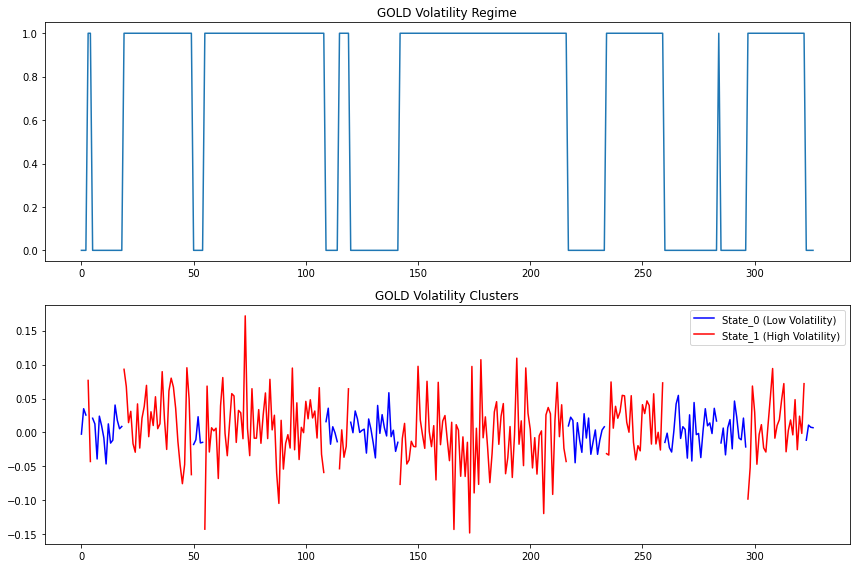

In [198]:
# Compute State Changes
returns0 = np.empty(len(Z))
returns1 = np.empty(len(Z))
returns0[:] = np.nan
returns1[:] = np.nan

# Create series for each state change
returns0[Z == 0] = returns[-split:][Z == 0]
returns1[Z == 1] = returns[-split:][Z == 1]

# Plot the Volatility Regime and the states
fig, ax = plt.subplots(figsize=(12,8))

plt.subplot(211)
plt.plot(Z)
plt.title(label='GOLD Volatility Regime')

plt.subplot(212)
plt.plot(returns0, label='State_0 (Low Volatility)', color='b')
plt.plot(returns1, label='State_1 (High Volatility)', color='r')
plt.title(label='GOLD Volatility Clusters')

plt.legend()
plt.tight_layout()

In [199]:
print(np.nanmedian(returns0))
np.nanmedian(returns1)

0.0035431692173464313


0.00424928438023553

In [200]:
Z

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,

In [201]:
Z_cap==Z

array([ True,  True,  True,  True,  True, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True, False,  True,  True,
        True, False, False, False,  True,  True,  True,  True, False,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,